In [1]:
# Set-up
%matplotlib inline
import matplotlib.pyplot as plt

# Built-in python modules
import math
import datetime
import warnings
warnings.filterwarnings(action='ignore')

# Python add-ons
import numpy as np
import pandas as pd
from statsmodels.api import qqplot

# Sandia pvlib-python
import pvlib

# Synthetic
import sys
sys.path.insert(1, '../../')
import src

# 1. Data

In [2]:
FILE = 'seville-15'

df = pd.read_csv(filepath_or_buffer=f'../data/{FILE}.csv', sep=',', decimal='.', index_col='timestamp', parse_dates=True)

# NaN
df = df.fillna(0)

# Ant data
df.loc[df['ghi_wm2'] <= 1.5, 'ghi_wm2'] = 0

df.head()

,ghi_wm2,tamb_c
timestamp,,
2019-01-01 00:00:00,0,6.5
2019-01-01 00:15:00,0,6.4
2019-01-01 00:30:00,0,6.3
2019-01-01 00:45:00,0,6.1
2019-01-01 01:00:00,0,6.0


# 2. Synthetic Irradiance Data Generation

## 2.1. Clear-Sky Index

According to **(Skartveit and Olseth, 1992)**, the clear-sky index ($k_c$) is the measured irradiance in the plane of array (in this case `ghi_wm2` data) normalized by the global irradiance (GHI) under clear sky conditions.

$$
k= \frac{H}{H_{cs}}
\tag{1}
$$

Where $H$ is the observed GHI in the plane of array, and $H_{cs}$ is the clear-sky GHI.

The main benefit is that the losses due to atmosphere are already accounted for as they are encompassed within clear-sky global horizontal irradiance ($H_{cs}$). This means that the losses described by the clear-sky index can be exclusively isolated to the influence of clouds. The clear-sky index, therefore, explains the optical losses associated to clouds.

The value of $k_c$ allows estimating the meteorological conditions of the day according to **(Larrañeta et al., 2015)**. Also, expressing irradiance in terms of $k_c$ is the closest approximation of stationarity with solar irradiance time series, according to (**Bright et al., 2021**). A stationary time series has the same mean, variance and auto-correlation over time.

**Note:** As the presence of clouds is not stationary (except over coarse temporal averages), and the indices represent losses due to clouds, a time series of $k_c$ are not perfectly stationary. That said, it effectively remove all influence of seasons and the daily curve of irradiance (from sunrise and sunset) from the time series (**Bright et al., 2021**).

In [3]:
# Location
latitude = 40.41
longitude = -3.70
tz = 'Europe/Madrid'
altitude = 680 # [m]

location = pvlib.location.Location(latitude, longitude, tz, altitude)

In [4]:
# Clear-sky irradiance (Hcs)
RESOLUTION = int(pd.Series(df.index.values).diff().median().total_seconds()/60)

hcs = location.get_clearsky(times=pd.date_range(start=df.index[0] - datetime.timedelta(days=1, hours=0, minutes=0),
                                                end=df.index[-1] + datetime.timedelta(days=1, hours=6, minutes=0),
                                                freq=f'{RESOLUTION}min',
                                                tz=None),
                            model='ineichen')

hcs.head()

,ghi,dni,dhi
2018-12-31 00:00:00,0.0,0.0,0.0
2018-12-31 00:15:00,0.0,0.0,0.0
2018-12-31 00:30:00,0.0,0.0,0.0
2018-12-31 00:45:00,0.0,0.0,0.0
2018-12-31 01:00:00,0.0,0.0,0.0


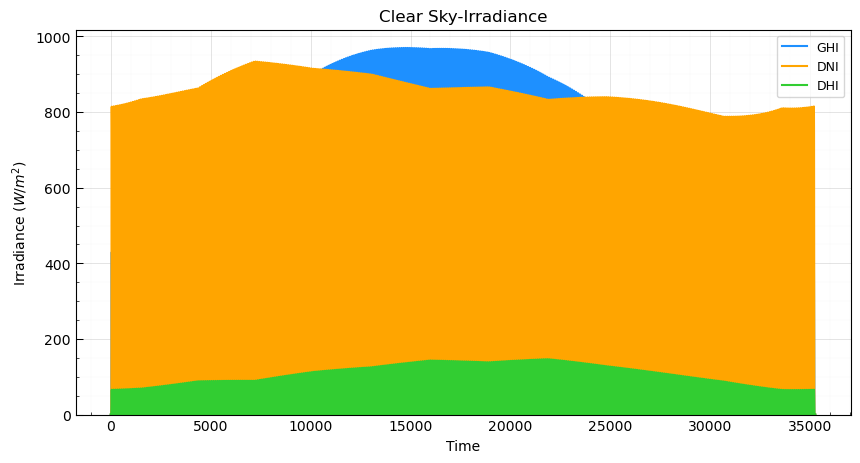

In [5]:
hor = 10
ver = 5
plt.figure(figsize=(hor, ver))

plt.plot(hcs['ghi'].values, color='dodgerblue', label='GHI') # Global horizontal irradiance
plt.plot(hcs['dni'].values, color='orange', label='DNI') # Direct normal irradiance
plt.plot(hcs['dhi'].values, color='limegreen', label='DHI') # Diffuse horizontal irradiance

plt.rcParams['axes.axisbelow'] = True

plt.title('Clear Sky-Irradiance')
plt.ylabel('Irradiance ($W/m^2$)')
plt.xlabel('Time')

plt.tick_params(which='major', direction='in', length=5, width=0.75, grid_alpha=0.3)
plt.tick_params(which='minor', direction='in', length=2.5, width=0.5, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.minorticks_on()
plt.ylim(0, None)
plt.xlim(None, None)
plt.grid(True)
plt.grid(visible=True, which='major', color='grey', linestyle='-', linewidth=0.5)
plt.grid(visible=True, which='minor', color='lightgrey', linestyle='-', linewidth=0.3, alpha=0.2)
plt.legend(loc='upper right', fontsize=9)
plt.tight_layout;

Same as (**Bright et al., 2021**) described, at sunrise and sunset the values of irradiance are in the order of 0 - 10 W/m2, $k_c$ become very sensitive to discrepancies between clear-sky estimate and measurement. It is common in solar energy engineering to ignore the first 5° of solar elevation.

In [6]:
# Append clear-sky irradiance to main dataframe
df = pd.merge(df, hcs['ghi'], left_index=True, right_index=True)
df = df.rename(columns={'ghi': 'hcs_wm2'})

# Clear-sky index (kc) to main dataframe
df['kc'] = df['ghi_wm2'].values / df['hcs_wm2'].values

# Filters
## NaN
df['kc'] = df['kc'].fillna(1)

# Replace kc > 1
df.loc[df['kc'] > 1, 'kc'] = 1

df.head()

,ghi_wm2,tamb_c,hcs_wm2,kc
2019-01-01 00:00:00,0,6.5,0.0,1.0
2019-01-01 00:15:00,0,6.4,0.0,1.0
2019-01-01 00:30:00,0,6.3,0.0,1.0
2019-01-01 00:45:00,0,6.1,0.0,1.0
2019-01-01 01:00:00,0,6.0,0.0,1.0


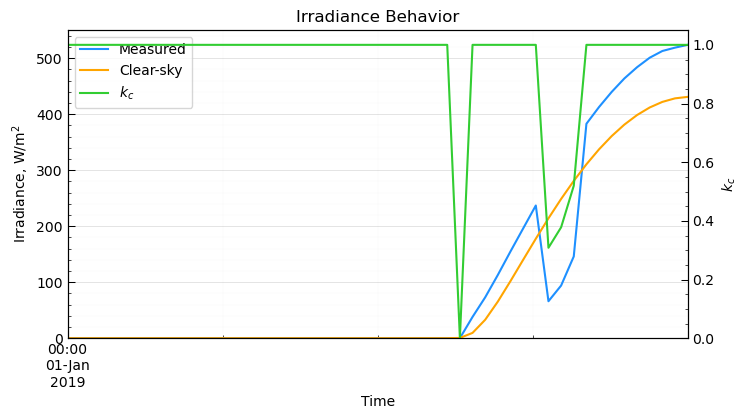

In [7]:
hor = 8
ver = 4
plt.figure(figsize=(hor, ver), dpi=100)

# GHI and Hcs
df['ghi_wm2'][0:50].plot(color='dodgerblue', label='Measured', xlabel='Time', ylabel='Irradiance, W/m$^2$', legend=True)
df['hcs_wm2'][0:50].plot(color='orange', label='Clear-sky', xlabel='Time', ylabel='Irradiance, W/m$^2$', legend=True)

plt.rcParams['axes.axisbelow'] = True

plt.title('Irradiance Behavior')
plt.xlabel('Time')

plt.tick_params(which='major', direction='in', length=5, width=0.75, grid_alpha=0.3)
plt.tick_params(which='minor', direction='in', length=2.5, width=0.5, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.minorticks_on()
plt.ylim(0, None)
plt.xlim(None, None)
plt.grid(True)
plt.grid(visible=True, which='major', color='grey', linestyle='-', linewidth=0.5)
plt.grid(visible=True, which='minor', color='lightgrey', linestyle='-', linewidth=0.3, alpha=0.2)
plt.legend(loc='best', fontsize=9)
plt.tight_layout;

# kc
df['kc'][0:50].plot(color='limegreen', label='$k_c$', secondary_y=True, xlabel='Time', ylabel='$k_c$', legend=True, mark_right=False)

plt.tick_params(which='major', direction='in', length=5, width=0.75, grid_alpha=0.3)
plt.tick_params(which='minor', direction='in', length=2.5, width=0.5, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.minorticks_on()
plt.ylim(0, None)
plt.xlim(None, None)
plt.tight_layout;

## 2.2. `analysis`: Function to extract descriptive statistics from irradiance data

In [8]:
TIMES = [f'{i}:0{j}' if j < 10 else f'{i}:{j}' for i in range(0, 24) for j in range(0, 60, RESOLUTION)]

MONTHS = {'1': 'Jan', '2': 'Feb', '3': 'Mar', '4': 'Apr', '5': 'May', '6': 'Jun',
          '7': 'Jul', '8': 'Aug', '9': 'Sep', '10': 'Oct', '11': 'Nov', '12': 'Dec'}

INVERSE_MONTHS = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
                  'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

MULTIINDEX = [(i,j) for i in range(0, 24) for j in range(0, 60, RESOLUTION)]

XTICKS = np.arange(start=0, stop=len(TIMES), step=50)
LABELS = [TIMES[i] for i in XTICKS]

### 2.2.1. Shapiro-Wilk, Anderson-Darling and Kolmogorov-Smirnov tests

In [9]:
LOOP_YEARS = df.index.year.unique().values
LOOP_MONTHS = df.index.month.unique().values
LOOP_SC = ['sc1', 'sc2', 'sc3', 'sc4', 'sc5']

LOOP_ANALYSIS = {}

for i in LOOP_YEARS:
    for j in LOOP_MONTHS:
        LOOP_ANALYSIS[f'{MONTHS[str(j)]}{i}'] = src.utils.analysis(df=df, year=i, month=j, irradiance_column='ghi_wm2', resolution=RESOLUTION, plot=False)

In [10]:
# For high resolution (e.g., 5 min), this cell takes ~10 min to run

DISTRIBUTIONS = pd.DataFrame()

for z in LOOP_ANALYSIS.keys():
    i = int(z[3:7]) # Year
    j = INVERSE_MONTHS[z[0:3]] # Month

    for k in LOOP_SC:
        df_to_check = LOOP_ANALYSIS[z]['bootstrap'][k]

        if (df_to_check.empty != True) and (len(df_to_check) >= 3):
            aux_df = pd.DataFrame(data={'year':i,
                                        'month': j,
                                        'sc': k,
                                        'shapiro_wilk': [src.utils.shapiro_wilk(data=d) for d in df_to_check.T.values],
                                        'anderson_darling': [src.utils.anderson_darling(data=d) for d in df_to_check.T.values],
                                        'lognormal_test': [src.utils.lognormal_test(data=d) for d in df_to_check.T.values]},
                                  index=df_to_check.columns).iloc[TIMES.index('6:00'):TIMES.index('18:00'),:] # 6:15 to 17:45h

            DISTRIBUTIONS = pd.concat([DISTRIBUTIONS, aux_df])

DISTRIBUTIONS.to_csv(f'../distributions/{FILE}/distributions.csv')

In [11]:
DISTRIBUTIONS.describe()

,year,month,shapiro_wilk,anderson_darling,lognormal_test
count,912.0,912.000000,912.000000,912.000000,912.000000
mean,2019.0,7.052632,0.216732,0.930921,0.164934
std,0.0,3.577812,0.333034,0.253727,0.270707
min,2019.0,1.000000,-0.000000,0.000000,0.000000
25%,2019.0,4.000000,0.000000,1.000000,0.000000
50%,2019.0,7.000000,0.010000,1.000000,0.000000
75%,2019.0,11.000000,0.330000,1.000000,0.270000
max,2019.0,12.000000,1.000000,1.000000,1.000000


In [12]:
# Gaussian distribution
complete_gaussian = (len(DISTRIBUTIONS[(DISTRIBUTIONS['shapiro_wilk'] > 0.05) & (DISTRIBUTIONS['anderson_darling'] == 1)]) / len(DISTRIBUTIONS)) * 100
print(f'{np.round(a=complete_gaussian, decimals=2)}% of the total data behaves as a Gaussian distribution according to Shapiro-Wilk and Anderson-Darling tests.')

# Lognormal distribution
complete_lognormal = (len(DISTRIBUTIONS[(DISTRIBUTIONS['shapiro_wilk'] <= 0.05) & (DISTRIBUTIONS['lognormal_test'] > 0.05)]) / len(DISTRIBUTIONS)) * 100
print(f'{np.round(a=complete_lognormal, decimals=2)}% of the total data behaves as a lognormal distribution.')

# Most likely lognormal distribution
possible_lognormal = (len(DISTRIBUTIONS[(DISTRIBUTIONS['shapiro_wilk'] > 0.05) & (DISTRIBUTIONS['lognormal_test'] > 0.05)]) / len(DISTRIBUTIONS)) * 100
print(f'{np.round(a=possible_lognormal, decimals=2)}% of the total data most likely behaves as a lognormal distribution.')

33.99% of the total data behaves as a Gaussian distribution according to Shapiro-Wilk and Anderson-Darling tests.
9.65% of the total data behaves as a lognormal distribution.
25.99% of the total data most likely behaves as a lognormal distribution.


In [13]:
GROUPED_DISTRIBUTIONS = DISTRIBUTIONS.groupby(by=['year', 'month', 'sc']).mean().round(decimals=2).astype({'anderson_darling': int})
GROUPED_DISTRIBUTIONS.to_csv(f'../distributions/{FILE}/grouped.csv')

In [14]:
GROUPED_DISTRIBUTIONS.describe()

,shapiro_wilk,anderson_darling,lognormal_test
count,19.000000,19.000000,19.000000
mean,0.216842,0.421053,0.164737
std,0.171466,0.507257,0.198197
min,0.000000,0.000000,0.000000
25%,0.080000,0.000000,0.015000
50%,0.200000,0.000000,0.050000
75%,0.355000,1.000000,0.290000
max,0.500000,1.000000,0.550000


In [15]:
# Gaussian distribution
grouped_gaussian = (len(GROUPED_DISTRIBUTIONS[(GROUPED_DISTRIBUTIONS['shapiro_wilk'] > 0.05) & (GROUPED_DISTRIBUTIONS['anderson_darling'] == 1)]) / len(GROUPED_DISTRIBUTIONS)) * 100
print(f'{np.round(a=grouped_gaussian, decimals=2)}% of the total data behaves as a Gaussian distribution according to Shapiro-Wilk and Anderson-Darling tests.')

# Lognormal distribution
grouped_lognormal = (len(GROUPED_DISTRIBUTIONS[(GROUPED_DISTRIBUTIONS['shapiro_wilk'] <= 0.05) & (GROUPED_DISTRIBUTIONS['lognormal_test'] > 0.05)]) / len(GROUPED_DISTRIBUTIONS)) * 100
print(f'{np.round(a=grouped_lognormal, decimals=2)}% of the total data behaves as a lognormal distribution.')

21.05% of the total data behaves as a Gaussian distribution according to Shapiro-Wilk and Anderson-Darling tests.
0.0% of the total data behaves as a lognormal distribution.


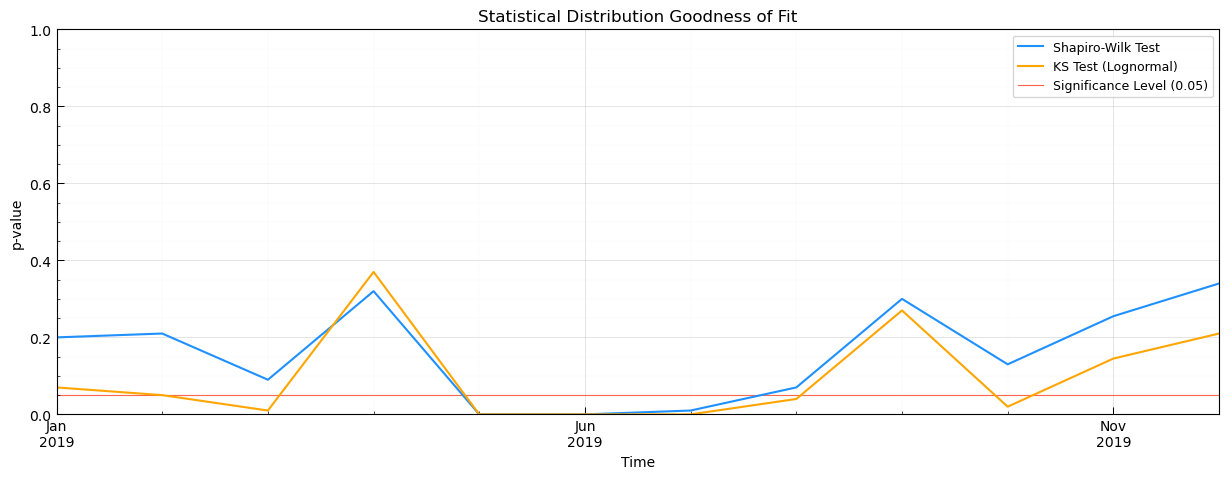

In [16]:
aux_grouped_distributions = GROUPED_DISTRIBUTIONS.groupby(['year', 'month']).mean()
x_axis = [f'{MONTHS[str(i[1])]}\n{i[0]}' for i in aux_grouped_distributions.index]

XTICKS = np.arange(start=0, stop=len(x_axis), step=5)
LABELS = [x_axis[i] for i in XTICKS]

hor = 15
ver = 5
plt.figure(figsize=(hor,ver), dpi=100)

plt.plot(aux_grouped_distributions['shapiro_wilk'].values, color='dodgerblue', label='Shapiro-Wilk Test')
plt.plot(aux_grouped_distributions['lognormal_test'].values, color='orange', label='KS Test (Lognormal)')
plt.axhline(y=0.05, linewidth=0.8, color='tomato', label='Significance Level (0.05)', zorder=0)

plt.title(f'Statistical Distribution Goodness of Fit')
plt.ylabel('p-value')
plt.xlabel('Time')
plt.tick_params(which='major', direction='in', length=5, width=0.75, grid_alpha=0.3)
plt.tick_params(which='minor', direction='in', length=2.5, width=0.5, grid_alpha=0.3)
plt.xticks(rotation=0, ticks=XTICKS, labels=LABELS)
plt.minorticks_on()
plt.ylim(0, 1)
plt.xlim(0, len(aux_grouped_distributions)-1)
plt.grid(True)
plt.grid(visible=True, which='major', color='grey', linestyle='-', linewidth=0.5)
plt.grid(visible=True, which='minor', color='lightgrey', linestyle='-', linewidth=0.3, alpha=0.2)
plt.tight_layout
plt.legend(loc='best', fontsize=9) # bbox_to_anchor=(1,1)

### 2.2.2. Histogram (Gaussian or lognormal distributions)

In [17]:
# Constants
TIMES = [f'{i}:0{j}' if j < 10 else f'{i}:{j}' for i in range(0, 24) for j in range(0, 60, RESOLUTION)]

MONTHS = {'1': 'Jan', '2': 'Feb', '3': 'Mar', '4': 'Apr', '5': 'May', '6': 'Jun',
          '7': 'Jul', '8': 'Aug', '9': 'Sep', '10': 'Oct', '11': 'Nov', '12': 'Dec'}

XTICKS = np.arange(start=0, stop=len(TIMES), step=10)
LABELS = [TIMES[i] for i in XTICKS]

# src.utils.analysis function example
YEAR = 2019
MONTH = 1

ANALYSIS = src.utils.analysis(df=df, year=YEAR, month=MONTH, irradiance_column='ghi_wm2', resolution=RESOLUTION, plot=False)

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

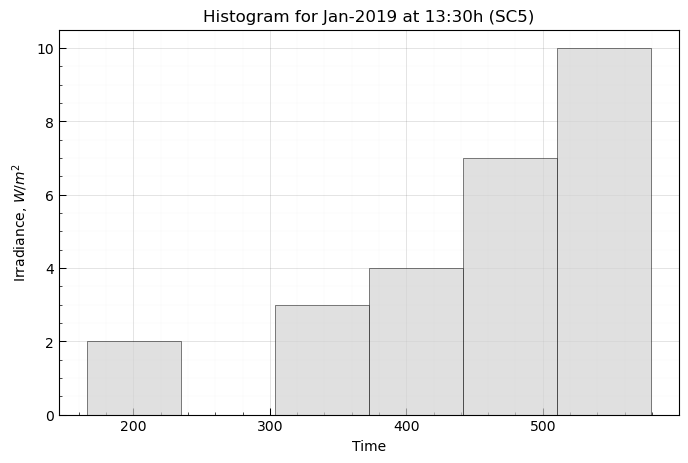

In [18]:
HOUR = 13
MINUTE = 30
SC = 'sc5'

df_to_hist = df[(df.index.year == YEAR) & (df.index.month == MONTH) & (df.index.day.isin(ANALYSIS['bootstrap'][SC].index)) & (df.index.hour == HOUR) & (df.index.minute == MINUTE)]['ghi_wm2'].values

hor = 8
ver = 5
plt.figure(figsize=(hor,ver))

plt.hist(x=df_to_hist, bins='auto', color='lightgrey', alpha=0.7, edgecolor='black', linewidth=0.5);

plt.title(f'Histogram for {MONTHS[str(MONTH)]}-{YEAR} at {HOUR}:{MINUTE}h ({str.upper(SC)})')
plt.ylabel('Irradiance, $W/m^2$')
plt.xlabel('Time')
plt.tick_params(which='major', direction='in', length=5, width=0.75, grid_alpha=0.3)
plt.tick_params(which='minor', direction='in', length=2.5, width=0.5, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.minorticks_on()
plt.ylim(0, None)
plt.xlim(None, None)
plt.grid(True)
plt.grid(visible=True, which='major', color='grey', linestyle='-', linewidth=0.5)
plt.grid(visible=True, which='minor', color='lightgrey', linestyle='-', linewidth=0.3, alpha=0.2)
plt.tight_layout
#plt.legend(loc='best', fontsize=9) # bbox_to_anchor=(1,1)

### 2.2.3. QQ-Plots

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

<Figure size 800x500 with 0 Axes>

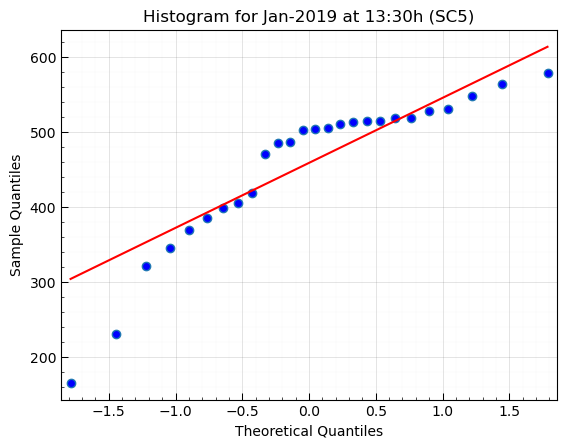

In [19]:
hor = 8
ver = 5
plt.figure(figsize=(hor,ver))

qqplot(df_to_hist, line='q', markerfacecolor='blue')

plt.title(f'Histogram for {MONTHS[str(MONTH)]}-{YEAR} at {HOUR}:{MINUTE}h ({str.upper(SC)})')
#plt.ylabel()
#plt.xlabel()
plt.tick_params(which='major', direction='in', length=5, width=0.75, grid_alpha=0.3)
plt.tick_params(which='minor', direction='in', length=2.5, width=0.5, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.minorticks_on()
plt.ylim(None, None)
plt.xlim(None, None)
plt.grid(True)
plt.grid(visible=True, which='major', color='grey', linestyle='-', linewidth=0.5)
plt.grid(visible=True, which='minor', color='lightgrey', linestyle='-', linewidth=0.3, alpha=0.2)
plt.tight_layout
#plt.legend(loc='best', fontsize=9) # bbox_to_anchor=(1,1)

# 3. Validations

In [20]:
SYNTHETIC = {'stochastic': {}, 'bootstrap': {}}
IC = 0.95
RUNS = 5

for i in LOOP_YEARS:
    for j in LOOP_MONTHS:
        for k in LOOP_SC:
            # Stochastic
            SYNTHETIC['stochastic'][f'{MONTHS[str(j)]}{i}-{k}'] = src.methods.autoregressive(data=df,
                                                                                             irradiance_column='ghi_wm2',
                                                                                             year=i,
                                                                                             month=j,
                                                                                             sky_condition=k,
                                                                                             method='stochastic',
                                                                                             IC=IC,
                                                                                             resolution=RESOLUTION,
                                                                                             runs=RUNS)
            # Bootstrap
            SYNTHETIC['bootstrap'][f'{MONTHS[str(j)]}{i}-{k}'] = src.methods.autoregressive(data=df,
                                                                                            irradiance_column='ghi_wm2',
                                                                                            year=i,
                                                                                            month=j,
                                                                                            sky_condition=k,
                                                                                            method='bootstrap',
                                                                                            IC=IC,
                                                                                            resolution=RESOLUTION,
                                                                                            runs=RUNS)

## 3.1. Variability metrics

In [21]:
VARIABILITY_METRICS = {'stochastic': {}, 'bootstrap': {}}
RUNS = 5

for m in ['stochastic', 'bootstrap']:
    for z in SYNTHETIC[m].keys():
        i = int(z[3:7]) # Year
        j = INVERSE_MONTHS[z[0:3]] # Month
        k = z[8:11] # Sky condition

        metrics = {'standard_deviation_increments': [[], []],
                    'stability_index': [[], []],
                    'iccdf': [[], []],
                    'variability_index': [[], []]}

        for _ in range(RUNS):
            try:
                aux = LOOP_ANALYSIS[f'{MONTHS[str(j)]}{i}']['bootstrap'][k].T.sample(n=1, axis=1)
                sample1 = aux.values.flatten()
                sample2 = SYNTHETIC[m][f'{MONTHS[str(j)]}{i}-{k}'].sample(n=1, axis=1).values.flatten()

                # Standard deviation of increments (SDI)
                metrics['standard_deviation_increments'][0].append(src.metrics.standard_deviation_increments(data=sample1))
                metrics['standard_deviation_increments'][1].append(src.metrics.standard_deviation_increments(data=sample2))

                # Stability index (SI)
                metrics['stability_index'][0].append(src.metrics.stability_index(data=sample1, threshold=100))
                metrics['stability_index'][1].append(src.metrics.stability_index(data=sample2, threshold=100))

                # Integrated complementary cumulative distribution function (ICCDF)
                metrics['iccdf'][0].append(src.metrics.iccdf(data=sample1))
                metrics['iccdf'][1].append(src.metrics.iccdf(data=sample2))

                # Variability index (VI)
                temp = df.loc[(df.index.year == i) & (df.index.month == j) & (df.index.day == aux.columns[0])]
                metrics['variability_index'][0].append(src.metrics.variability_index(timestamps=temp.index, ghi=sample1, hcs=temp['hcs_wm2'].values).mean())
                metrics['variability_index'][1].append(src.metrics.variability_index(timestamps=temp.index, ghi=sample2, hcs=temp['hcs_wm2'].values).mean())

            except:
                pass

        for _ in metrics.keys():
            metrics[_] = np.mean(metrics[_], axis=1)

        VARIABILITY_METRICS[m][f'{MONTHS[str(j)]}{i}-{k}'] = metrics

In [22]:
metrics_stochastic = pd.DataFrame(VARIABILITY_METRICS['stochastic']).T
metrics_bootstrap = pd.DataFrame(VARIABILITY_METRICS['bootstrap']).T

# Stochastic
pe_stochastic = metrics_stochastic * 0

pe_stochastic['month'] = [INVERSE_MONTHS[i[0:3]] for i in pe_stochastic.index]
pe_stochastic['sc'] = [i[8:11] for i in pe_stochastic.index]

for i in metrics_stochastic.columns:
    pe_stochastic[i] = [src.metrics.wrapper_percentage_error(j) for j in metrics_stochastic[i]]

pe_stochastic = pe_stochastic.fillna(0)

# Bootstrap
pe_bootstrap = metrics_bootstrap * 0

pe_bootstrap['month'] = [INVERSE_MONTHS[i[0:3]] for i in pe_bootstrap.index]
pe_bootstrap['sc'] = [i[8:11] for i in pe_bootstrap.index]

for i in metrics_bootstrap.columns:
    pe_bootstrap[i] = [src.metrics.wrapper_percentage_error(j) for j in metrics_bootstrap[i]]

pe_bootstrap = pe_bootstrap.fillna(0)

In [23]:
# Percentage error monthly average
VM_STOCHASTIC_MONTH = pe_stochastic.groupby(by='month').mean().round(decimals=2)
VM_BOOTSTRAP_MONTH = pe_bootstrap.groupby(by='month').mean().round(decimals=2)

# Percentage error sky condition average
VM_STOCHASTIC_SC = pe_stochastic.groupby(by='sc').mean().round(decimals=2)
VM_BOOTSTRAP_SC = pe_bootstrap.groupby(by='sc').mean().round(decimals=2)

In [24]:
# Download
VM_STOCHASTIC_MONTH.to_csv(f'../metrics/variability/{FILE}/stochastic_month.csv')
VM_BOOTSTRAP_MONTH.to_csv(f'../metrics/variability/{FILE}/bootstrap_month.csv')
VM_STOCHASTIC_SC.to_csv(f'../metrics/variability/{FILE}/stochastic_sc.csv')
VM_BOOTSTRAP_SC.to_csv(f'../metrics/variability/{FILE}/bootstrap_sc.csv')

In [25]:
VM_STOCHASTIC_MONTH.describe()

,standard_deviation_increments,stability_index,iccdf,variability_index
count,12.000000,12.0,12.000000,12.000000
mean,9.348333,0.0,6.560000,3.834167
std,8.612670,0.0,7.067962,3.736920
min,0.890000,0.0,0.280000,0.710000
25%,3.610000,0.0,0.940000,1.197500
50%,4.600000,0.0,3.695000,2.380000
75%,13.565000,0.0,12.355000,4.795000
max,28.660000,0.0,18.370000,13.910000


In [26]:
VM_BOOTSTRAP_MONTH.describe()

,standard_deviation_increments,stability_index,iccdf,variability_index
count,12.000000,12.0,12.000000,12.000000
mean,12.195000,0.0,5.524167,5.615000
std,13.383783,0.0,4.941175,5.899827
min,0.200000,0.0,0.540000,0.740000
25%,3.035000,0.0,2.395000,2.265000
50%,6.210000,0.0,4.110000,3.305000
75%,19.445000,0.0,7.662500,6.685000
max,40.120000,0.0,17.560000,21.020000


In [27]:
VM_STOCHASTIC_SC.describe()

,standard_deviation_increments,stability_index,iccdf,variability_index,month
count,5.000000,5.0,5.000000,5.000000,5.0
mean,9.350000,0.0,6.562000,3.834000,6.5
std,12.268621,0.0,4.856719,4.822368,0.0
min,1.020000,0.0,1.010000,0.390000,6.5
25%,2.670000,0.0,2.690000,1.630000,6.5
50%,2.760000,0.0,6.270000,1.940000,6.5
75%,9.870000,0.0,10.630000,2.900000,6.5
max,30.430000,0.0,12.210000,12.310000,6.5


In [28]:
VM_BOOTSTRAP_SC.describe()

,standard_deviation_increments,stability_index,iccdf,variability_index,month
count,5.000000,5.0,5.000000,5.000000,5.0
mean,12.194000,0.0,5.524000,5.614000,6.5
std,13.891115,0.0,3.894962,4.805115,0.0
min,1.150000,0.0,2.140000,1.570000,6.5
25%,2.860000,0.0,3.410000,1.630000,6.5
50%,8.860000,0.0,4.070000,4.330000,6.5
75%,12.420000,0.0,5.960000,7.520000,6.5
max,35.680000,0.0,12.040000,13.020000,6.5


## 3.2. Comparison of statistical distributions

In [29]:
STATISTICAL_METRICS = {'stochastic': {}, 'bootstrap': {}}
RUNS = 5

for m in ['stochastic', 'bootstrap']:
    for z in SYNTHETIC[m].keys():
        i = int(z[3:7]) # Year
        j = INVERSE_MONTHS[z[0:3]] # Month
        k = z[8:11] # Sky condition

        metrics = {'kolmogorov_smirnov': [],
                   'kullback_leibler_divergence': [],
                   'overlapping_coefficient': []}

        for _ in range(RUNS):
            try:
                sample1 = LOOP_ANALYSIS[f'{MONTHS[str(j)]}{i}']['bootstrap'][k].T.sample(n=1, axis=1).values.flatten()
                sample2 = SYNTHETIC[m][f'{MONTHS[str(j)]}{i}-{k}'].sample(n=1, axis=1).values.flatten()

                # Kolmogorov-Smirnov Test (KS)
                metrics['kolmogorov_smirnov'].append(src.metrics.kolmogorov_smirnov(sample1=sample1, sample2=sample2))

                # Kullback-Leibler Divergence (KLD)
                metrics['kullback_leibler_divergence'].append(src.metrics.kullback_leibler_divergence(sample1=sample1, sample2=sample2))

                # Overlapping coefficient (OVC)
                metrics['overlapping_coefficient'].append(src.metrics.overlapping_coefficient(sample1=sample1, sample2=sample2))

            except:
                pass

        for _ in metrics.keys():
            metrics[_] = np.mean(metrics[_])

        STATISTICAL_METRICS[m][f'{MONTHS[str(j)]}{i}-{k}'] = metrics

In [30]:
ovc = pd.Series([STATISTICAL_METRICS['bootstrap'][i]['overlapping_coefficient'] for i in STATISTICAL_METRICS['bootstrap'].keys()])
ovc.describe()

count    39.000000
mean      0.825855
std       0.135480
min       0.622917
25%       0.701042
50%       0.810417
75%       0.989583
max       1.000000
dtype: float64

In [31]:
# Stochastic
metrics_stochastic = pd.DataFrame(STATISTICAL_METRICS['stochastic']).T
metrics_stochastic['month'] = [INVERSE_MONTHS[i[0:3]] for i in metrics_stochastic.index]
metrics_stochastic['sc'] = [i[8:11] for i in metrics_stochastic.index]
metrics_stochastic = metrics_stochastic.fillna(0)

# Bootstrap
metrics_bootstrap = pd.DataFrame(STATISTICAL_METRICS['bootstrap']).T
metrics_bootstrap['month'] = [INVERSE_MONTHS[i[0:3]] for i in metrics_bootstrap.index]
metrics_bootstrap['sc'] = [i[8:11] for i in metrics_bootstrap.index]
metrics_bootstrap = metrics_bootstrap.fillna(0)

In [32]:
# Monthly average
SM_STOCHASTIC_MONTH = metrics_stochastic.groupby(by='month').mean().round(decimals=2)
SM_BOOTSTRAP_MONTH = metrics_bootstrap.groupby(by='month').mean().round(decimals=2)

# Sky condition average
SM_STOCHASTIC_SC = metrics_stochastic.groupby(by='sc').mean().round(decimals=2)
SM_BOOTSTRAP_SC = metrics_bootstrap.groupby(by='sc').mean().round(decimals=2)

In [33]:
# Download
SM_STOCHASTIC_MONTH.to_csv(f'../metrics/statistical/{FILE}/stochastic_month.csv')
SM_BOOTSTRAP_MONTH.to_csv(f'../metrics/statistical/{FILE}/bootstrap_month.csv')
SM_STOCHASTIC_SC.to_csv(f'../metrics/statistical/{FILE}/stochastic_sc.csv')
SM_BOOTSTRAP_SC.to_csv(f'../metrics/statistical/{FILE}/bootstrap_sc.csv')

In [34]:
SM_STOCHASTIC_MONTH.describe()

,kolmogorov_smirnov,kullback_leibler_divergence,overlapping_coefficient
count,12.000000,12.00000,12.000000
mean,0.510000,0.15000,0.520833
std,0.230138,0.09458,0.249343
min,0.150000,0.00000,0.120000
25%,0.340000,0.06500,0.320000
50%,0.595000,0.18500,0.635000
75%,0.677500,0.21500,0.702500
max,0.790000,0.29000,0.830000


In [35]:
SM_BOOTSTRAP_MONTH.describe()

,kolmogorov_smirnov,kullback_leibler_divergence,overlapping_coefficient
count,12.000000,12.000000,12.000000
mean,0.508333,0.185833,0.537500
std,0.245610,0.131042,0.254206
min,0.150000,0.000000,0.130000
25%,0.280000,0.087500,0.322500
50%,0.580000,0.165000,0.665000
75%,0.645000,0.282500,0.705000
max,0.890000,0.390000,0.860000


In [36]:
SM_STOCHASTIC_SC.describe()

,kolmogorov_smirnov,kullback_leibler_divergence,overlapping_coefficient,month
count,5.000000,5.000000,5.000000,5.0
mean,0.510000,0.150000,0.524000,6.5
std,0.177482,0.104163,0.152742,0.0
min,0.280000,0.030000,0.300000,6.5
25%,0.360000,0.080000,0.430000,6.5
50%,0.600000,0.150000,0.610000,6.5
75%,0.640000,0.190000,0.640000,6.5
max,0.670000,0.300000,0.640000,6.5


In [37]:
SM_BOOTSTRAP_SC.describe()

,kolmogorov_smirnov,kullback_leibler_divergence,overlapping_coefficient,month
count,5.000000,5.000000,5.00000,5.0
mean,0.506000,0.190000,0.53600,6.5
std,0.145362,0.167033,0.15225,0.0
min,0.290000,0.040000,0.31000,6.5
25%,0.450000,0.070000,0.45000,6.5
50%,0.520000,0.160000,0.61000,6.5
75%,0.610000,0.220000,0.64000,6.5
max,0.660000,0.460000,0.67000,6.5


## 3.3. Energy production

In [38]:
INVERTER = pvlib.pvsystem.retrieve_sam(name='CECInverter')['ABB__TRIO_50_0_TL_OUTD_US_480__480V_']
MODULE = pvlib.pvsystem.retrieve_sam(name='CECMod')['LG_Electronics_Inc__LG400N2W_A5']
MPS = 16 # Modules per string
SPI = 8 # Strings per inverter
LOSS = 26.9

In [39]:
# Module temperature with NOCT equation
df['tmod_c'] = df['tamb_c'] + (((MODULE['T_NOCT'] - 20)/800) * df['ghi_wm2'])

TMOD = np.mean(df['tmod_c'].loc[(df.index.hour >= 6) & (df.index.hour < 18)])

In [40]:
ENERGY_METRIC = {'stochastic': {}, 'bootstrap': {}}
RUNS = 5

for m in ['stochastic', 'bootstrap']:
    for z in SYNTHETIC[m].keys():
        i = int(z[3:7]) # Year
        j = INVERSE_MONTHS[z[0:3]] # Month
        k = z[8:11] # Sky condition

        metrics = [[], []]

        for _ in range(RUNS):
            try:
                sample1 = LOOP_ANALYSIS[f'{MONTHS[str(j)]}{i}']['bootstrap'][k].T.sample(n=1, axis=1).values.flatten()
                sample2 = SYNTHETIC[m][f'{MONTHS[str(j)]}{i}-{k}'].sample(n=1, axis=1).values.flatten()

                # Energy production
                metrics[0].append(src.metrics.energy(irradiance=sample1, resolution=RESOLUTION, tmod=TMOD, inverter=INVERTER, module=MODULE, mps=MPS, spi=SPI, loss=LOSS))
                metrics[1].append(src.metrics.energy(irradiance=sample2, resolution=RESOLUTION, tmod=TMOD, inverter=INVERTER, module=MODULE, mps=MPS, spi=SPI, loss=LOSS))

            except:
                pass

        ENERGY_METRIC[m][f'{MONTHS[str(j)]}{i}-{k}'] = np.mean(metrics, axis=1)

In [41]:
# Stochastic
metrics_stochastic = pd.DataFrame(ENERGY_METRIC['stochastic'], index=['real', 'synthetic']).T

metrics_stochastic['month'] = [INVERSE_MONTHS[i[0:3]] for i in metrics_stochastic.index]
metrics_stochastic['sc'] = [i[8:11] for i in metrics_stochastic.index]

metrics_stochastic['percentage_error'] = src.metrics.percentage_error(target=metrics_stochastic['real'], predicted=metrics_stochastic['synthetic'])

metrics_stochastic = metrics_stochastic.fillna(0)

# Bootstrap
metrics_bootstrap = pd.DataFrame(ENERGY_METRIC['bootstrap'], index=['real', 'synthetic']).T

metrics_bootstrap['month'] = [INVERSE_MONTHS[i[0:3]] for i in metrics_bootstrap.index]
metrics_bootstrap['sc'] = [i[8:11] for i in metrics_bootstrap.index]

metrics_bootstrap['percentage_error'] = src.metrics.percentage_error(target=metrics_bootstrap['real'], predicted=metrics_bootstrap['synthetic'])

metrics_bootstrap = metrics_bootstrap.fillna(0)

In [42]:
# Percentage error monthly average
EM_STOCHASTIC_MONTH = metrics_stochastic.groupby(by='month').mean().round(decimals=2)
EM_BOOTSTRAP_MONTH = metrics_bootstrap.groupby(by='month').mean().round(decimals=2)

# Percentage error sky condition average
EM_STOCHASTIC_SC = metrics_stochastic.groupby(by='sc').mean().round(decimals=2)
EM_BOOTSTRAP_SC = metrics_bootstrap.groupby(by='sc').mean().round(decimals=2)

In [43]:
# Download
EM_STOCHASTIC_MONTH.to_csv(f'../metrics/energy/{FILE}/stochastic_month.csv')
EM_BOOTSTRAP_MONTH.to_csv(f'../metrics/energy/{FILE}/bootstrap_month.csv')
EM_STOCHASTIC_SC.to_csv(f'../metrics/energy/{FILE}/stochastic_sc.csv')
EM_BOOTSTRAP_SC.to_csv(f'../metrics/energy/{FILE}/bootstrap_sc.csv')

In [44]:
EM_STOCHASTIC_MONTH.describe()

,real,synthetic,percentage_error
count,12.000000,12.000000,12.000000
mean,70557.917500,67743.437500,4.925000
std,38901.623602,37416.900456,4.668705
min,26632.720000,25531.340000,0.100000
25%,41165.735000,41220.490000,1.907500
50%,61960.100000,56152.035000,3.230000
75%,84603.285000,77346.522500,7.140000
max,148516.340000,140484.900000,15.780000


In [45]:
EM_BOOTSTRAP_MONTH.describe()

,real,synthetic,percentage_error
count,12.000000,12.000000,12.000000
mean,72200.419167,67940.139167,4.567500
std,39597.134547,36473.462237,4.102609
min,26652.350000,24479.190000,0.640000
25%,45124.557500,41828.422500,1.595000
50%,63589.920000,62544.215000,3.465000
75%,85864.395000,76362.477500,6.320000
max,154909.630000,137660.820000,14.080000


In [46]:
EM_STOCHASTIC_SC.describe()

,real,synthetic,month,percentage_error
count,5.000000,5.000000,5.0,5.00000
mean,70557.918000,67743.440000,6.5,4.92400
std,69174.453305,64013.929308,0.0,2.57861
min,25766.710000,23958.740000,6.5,2.25000
25%,33563.790000,33778.950000,6.5,3.28000
50%,41174.510000,41601.680000,6.5,3.72000
75%,60100.740000,59520.860000,6.5,7.53000
max,192183.840000,179856.970000,6.5,7.84000


In [47]:
EM_BOOTSTRAP_SC.describe()

,real,synthetic,month,percentage_error
count,5.00000,5.000000,5.0,5.000000
mean,72200.41800,67940.140000,6.5,4.568000
std,70957.40599,64502.814889,0.0,4.300659
min,25681.77000,22855.490000,6.5,1.030000
25%,36058.08000,33055.740000,6.5,1.260000
50%,41940.74000,42840.220000,6.5,2.500000
75%,60183.11000,60295.080000,6.5,7.220000
max,197138.39000,180654.170000,6.5,10.830000


## 3.4. Cumulative density functions (CDF)

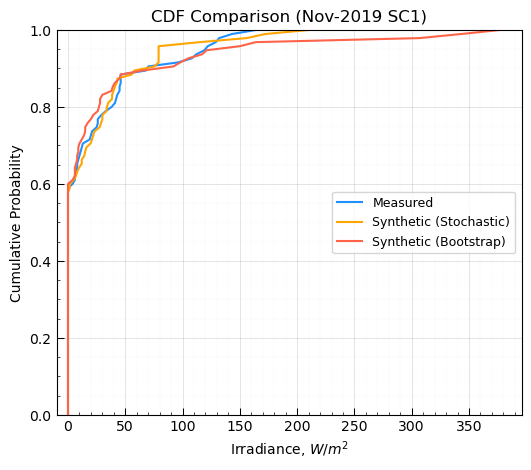

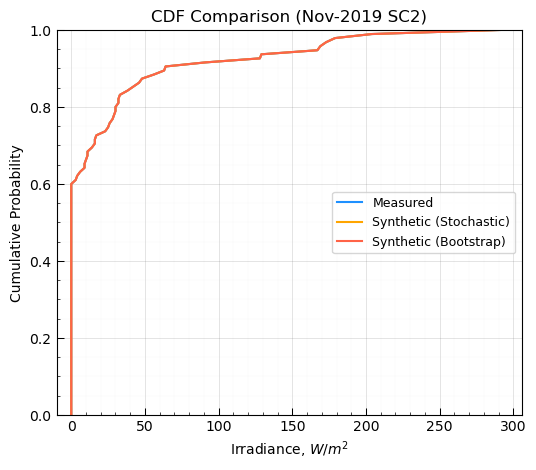

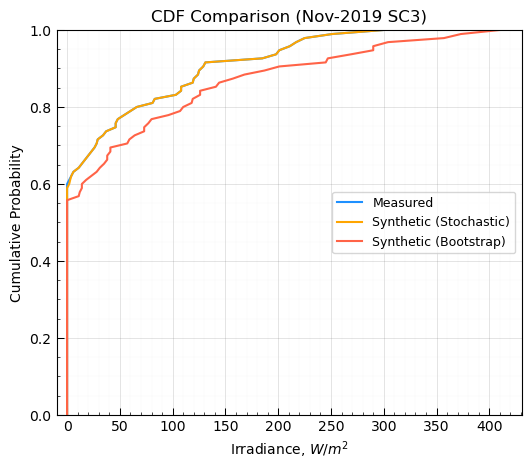

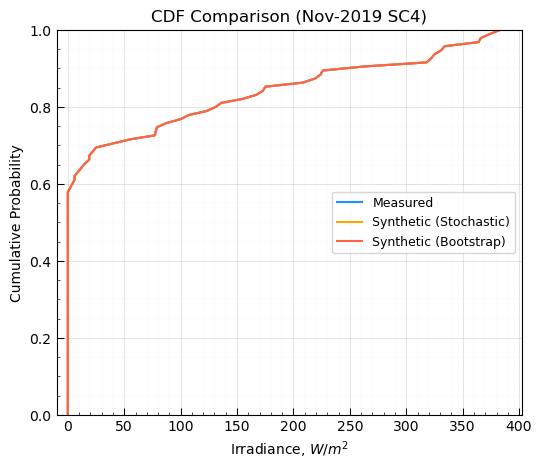

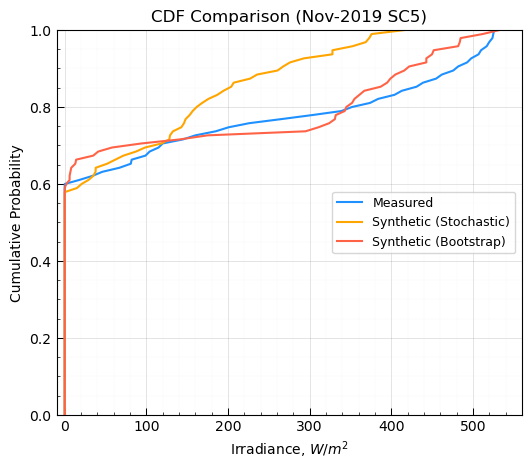

In [48]:
YY = 2019
MM = 'Nov'

for i in LOOP_SC:
    x, y = src.utils.cdf(data=LOOP_ANALYSIS[f'{MM}{YY}']['bootstrap'][i].T.sample(n=1, axis=1).iloc[:,0].values)
    xs, ys = src.utils.cdf(data=SYNTHETIC['stochastic'][f'{MM}{YY}-{i}'].sample(n=1, axis=1).iloc[:,0].values)
    xb, yb = src.utils.cdf(data=SYNTHETIC['bootstrap'][f'{MM}{YY}-{i}'].sample(n=1, axis=1).iloc[:,0].values)

    hor = 6
    ver = 5
    plt.figure(figsize=(hor,ver), dpi=100)

    plt.plot(x, y, color='dodgerblue', label='Measured')
    plt.plot(xs, ys, color='orange', label='Synthetic (Stochastic)')
    plt.plot(xb, yb, color='tomato', label='Synthetic (Bootstrap)')

    plt.title(f'CDF Comparison ({MM}-{YY} {str.upper(i)})')
    plt.ylabel('Cumulative Probability')
    plt.xlabel('Irradiance, $W/m^2$')
    plt.tick_params(which='major', direction='in', length=5, width=0.75, grid_alpha=0.3)
    plt.tick_params(which='minor', direction='in', length=2.5, width=0.5, grid_alpha=0.3)
    plt.xticks(rotation=0)
    plt.minorticks_on()
    plt.ylim(0, 1)
    plt.xlim(-10, None)
    plt.grid(True)
    plt.grid(visible=True, which='major', color='grey', linestyle='-', linewidth=0.5)
    plt.grid(visible=True, which='minor', color='lightgrey', linestyle='-', linewidth=0.3, alpha=0.2)
    plt.tight_layout
    plt.legend(loc='center right', fontsize=9) # bbox_to_anchor=(1,1)